In [278]:
import numpy as np 
import pandas as pd 
import pandas_datareader.data as pdr 
import matplotlib.pyplot as plt 
import datetime 
import torch 
import torch.nn as nn 
from torch.autograd import Variable 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [279]:
data_march = pd.read_csv("/content/drive/MyDrive/2021/2021년 미래기술 챌린지_211002/주문3월.csv", low_memory=False)
data_april = pd.read_csv("/content/drive/MyDrive/2021/2021년 미래기술 챌린지_211005/주문데이터/1-2. 이커머스 FC주문 데이터_4월.csv", low_memory=False)
data_may = pd.read_csv("/content/drive/MyDrive/2021/2021년 미래기술 챌린지_211005/주문데이터/1-3. 이커머스 FC주문 데이터_5월.csv", low_memory=False)
data_june = pd.read_csv("/content/drive/MyDrive/2021/2021년 미래기술 챌린지_211005/주문데이터/1-4. 이커머스 FC주문 데이터_6월.csv", low_memory=False)

In [280]:
data_march

,CORP_ID,REF_ORD_NO,BKG_NO,BKG_TYP,BKG_DATE,BKG_TIME,SHPR_CD,INV_AMT,ITEM_SEQ,ITEM_CD,BRAND_NM,ITEM_QTY,ITEM_AMT,IF_YN,ORDER_CRT_DATETIME,DLV_DV,REF_ITEM_SEQ,ORDER_IDX,ORDER_YN,DLVPREARRBRANCD,DLVPREARREMPNICKNM,DLVCLSFCD,DLVSUBCLSFCD,INS_ID,INS_DATE,INS_TIME,POST_ZONE,SPLIT_EXEC_YN,SHPR_ADDR_1,SHPR_ADDR_2,CNEE_ADDR_1,CNEE_ADDR_2
0,KX007,2021030365922551,KX007210303370934,7,20210303,35510,90001302,22400.0,2,134265392,단일상품,1,14900.0,N,2.021030e+13,1.0,2021030323885041,2021030323885041,Y,7484,C06,5Z73,1,iNEXBatch,20210303,131425,3.0,N,세종특별자치시,NaN,서울특별시,서대문구
1,KX007,2021030365922951,KX007210303371080,7,20210303,35521,90001441,20900.0,1,4610261043_2,조합형옵션상품,1,20900.0,N,2.021030e+13,1.0,2021030323885721,2021030323885721,Y,6427,M09,6R67,4,iNEXBatch,20210303,131425,50.0,N,경기도,광주시,경상남도,김해시
2,KX007,2021030365924361,KX007210303371081,7,20210303,35513,90001441,37900.0,1,4936599538_1,조합형옵션상품,1,37900.0,N,2.021030e+13,1.0,2021030323887981,2021030323887981,Y,6158,L32,9Y25,0,iNEXBatch,20210303,131425,53.0,N,경기도,광주시,경상남도,거제시
3,KX007,2021030365928921,KX007210303371205,7,20210303,35608,90001542,69800.0,1,3858391637_1,조합형옵션상품,1,69800.0,N,2.021030e+13,1.0,2021030323895281,2021030323895281,Y,8909,D21,1N65,1,iNEXBatch,20210303,131425,6.0,N,경기도,광주시,서울특별시,서초구
4,KX007,2021030365930451,KX007210303370967,7,20210303,35551,90001341,73700.0,1,4631307460,단일상품,1,39800.0,N,2.021030e+13,1.0,2021030323897651,2021030323897651,Y,2777,R15,3D84,1,iNEXBatch,20210303,131425,10.0,N,경기도,광주시,경기도,김포시
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309347,KX007,2021040163863411,KX007210401807629,7,20210331,235554,90001582,19500.0,1,161523952_5,조합형옵션상품,1,19500.0,N,2.021033e+13,1.0,2021040124539761,2021040124539761,Y,M53P,G50,6R69,2p,iNEXBatch,20210401,174255,46.0,N,경기도,안산시,부산광역시,북구
309348,KX007,2021040163894031,KX007210401807630,7,20210331,235800,90001582,43600.0,1,4789343708_3,조합형옵션상품,1,43600.0,N,2.021033e+13,1.0,2021040124590951,2021040124590951,Y,6877,F55,6N21,2p,iNEXBatch,20210401,174255,49.0,N,경기도,안산시,부산광역시,서구
309349,KX007,1617235699003,KX007210401806392,7,20210331,0,90001502,0.0,1,100034,NaN,1,0.0,N,NaN,1.0,NaN,33010508,Y,7696,O76,3H14,0,BATCH,20210401,173600,21.0,N,경기,광주시,인천광역시,NaN
309350,KX007,1617235754497,KX007210401806393,7,20210331,0,90001502,0.0,1,100032,NaN,1,0.0,N,NaN,1.0,NaN,33010507,Y,4746,L10,4C55,2,BATCH,20210401,173600,16.0,N,경기,광주시,경기도,NaN


In [323]:
def make_lstm_data():
  data = [data_march, data_april, data_may, data_june]
  month_name = ['march', 'april', 'may', 'june']
  date = [[],[],[],[]]
  date_per_qty = [[],[],[],[]]
  order_date_march = [[],[],[],[]]

  date[0] = sorted(data_march.BKG_DATE.unique())
  date[1] = sorted(data_april.BKG_DATE.unique())
  date[2] = sorted(data_may.BKG_DATE.unique())
  date[3] = sorted(data_june.BKG_DATE.unique())
  
  date_dic = [{},{},{},{}]
  for idx, mn in enumerate(month_name):
    for d in date[idx]:
      date_dic[idx][d] = sum(data[idx].loc[(data[idx].BKG_DATE == d)].ITEM_QTY)

  for idx in range(len(date_dic)):
    date_per_qty[idx] = list(date_dic[idx].values())
    order_date[idx] = list(date_dic[idx].keys())
  
  result = pd.DataFrame(order_date[0],columns=['주문날짜'])
  result['일별수량'] = date_per_qty[0]

  for idx in range(1,4):
    tmp = pd.DataFrame(order_date[idx],columns=['주문날짜'])
    tmp['일별수량'] = date_per_qty[idx]
    result = pd.concat([result,tmp], axis=0)
  
  result = result.reset_index().drop('index',axis=1)
  # lstm_y = result.일별수량
  # lstm_x = result.set_index('주문날짜')
  # print(lstm_y)
  # print(lstm_x)
  return result
  
lstm_data = make_lstm_data()
lstm_data

,주문날짜,일별수량
0,20210301,11197
1,20210302,17655
2,20210303,17322
3,20210304,13203
4,20210305,24565
...,...,...
117,20210626,20186
118,20210627,25808
119,20210628,40704
120,20210629,29409


In [324]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

sc = MinMaxScaler()
# x = sc.fit_transform(x)

def sliding_windows(data, seq_length):
  
  x = []
  y = []

  for i in range(len(data)-seq_length-1):
    _x = data[i:(i+seq_length)]
    _y = data[i+seq_length]
    x.append(_x)
    y.append(_y)

  return np.array(x), np.array(y)

seq_length = 4
x, y = sliding_windows(lstm_data.일별수량, seq_length)

In [325]:
columns = ['CORP_ID', 'BKG_DATE', 'SHPR_CD', 'ITEM_SEQ', 'ITEM_CD', 'ITEM_QTY', 'ITEM_AMT', 
           'BRAND_NM', 'POST_ZONE']

In [326]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.15, random_state=42)

x_train_tensors = Variable(torch.Tensor(x_train))
x_test_tensors = Variable(torch.Tensor(x_test))
y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))
x_train_tensors_final = torch.reshape(x_train_tensors, (x_train_tensors.shape[0], 1, x_train_tensors.shape[1]))
x_test_tensors_final = torch.reshape(x_test_tensors, (x_test_tensors.shape[0], 1, x_test_tensors.shape[1]))
print("Training Shape", x_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", x_test_tensors_final.shape, y_test_tensors.shape)

Training Shape torch.Size([99, 1, 4]) torch.Size([99])
Testing Shape torch.Size([18, 1, 4]) torch.Size([18])


In [327]:
y_train_tensors.shape[0]

99

In [328]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.15, random_state=42)

x_train_tensors = Variable(torch.Tensor(x_train))
x_test_tensors = Variable(torch.Tensor(x_test))
y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))
x_train_tensors_final = torch.reshape(x_train_tensors, (x_train_tensors.shape[0], x_train_tensors.shape[1], 1))
x_test_tensors_final = torch.reshape(x_test_tensors, (x_test_tensors.shape[0], x_test_tensors.shape[1], 1))
y_train_tensors = torch.reshape(y_train_tensors, (y_train_tensors.shape[0], 1))
y_test_tensors = torch.reshape(y_test_tensors, (y_test_tensors.shape[0], 1))
print("Training Shape", x_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", x_test_tensors_final.shape, y_test_tensors.shape)

Training Shape torch.Size([99, 4, 1]) torch.Size([99, 1])
Testing Shape torch.Size([18, 4, 1]) torch.Size([18, 1])


In [329]:
device = 'cpu'

In [330]:
class LSTM1(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTM1, self).__init__() 
    self.num_classes = num_classes #number of classes
    self.num_layers = num_layers #number of layers
    self.input_size = input_size #input size
    self.hidden_size = hidden_size #hidden state
    self.seq_length = seq_length #sequence length
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True) #lstm
    self.fc_1 = nn.Linear(hidden_size, 128) #fully connected 1
    self.fc = nn.Linear(128, num_classes) #fully connected last layer
    self.relu = nn.ReLU()

  def forward(self,x):
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #hidden state
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #internal state 
    # Propagate input through LSTM
    output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
    hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
    out = self.relu(hn)
    out = self.fc_1(out) #first Dense
    out = self.relu(out) #relu
    out = self.fc(out) #Final Output
    return out

In [347]:
num_epochs = 500 #1000 epochs
lr = 0.01 #0.001 lr

input_size = 1 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, x_train_tensors_final.shape[1]).to(device)

loss_function = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=lr)  # adam optimizer

In [348]:
for epoch in range(num_epochs + 1):
  outputs = lstm1.forward(x_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
  # obtain the loss function
  loss = loss_function(outputs, y_train_tensors.to(device))
  loss.backward() #calculates the loss of the loss function
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0: 
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    print(outputs)

Epoch: 0, loss: 3352787968.00000
tensor([[0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.0163],
        [0.01

In [310]:
lstm1.eval()
train_predict = lstm1(x_test_tensors_final)

train_predict
# x_test_tensors_final
# data_predict = train_predict.data.numpy()
# dataY_plot = dataY.data.numpy()

tensor([[26835.2500],
        [26835.2500],
        [26835.2500],
        [26835.2500],
        [26835.2500],
        [26835.2500],
        [26835.2500],
        [26835.2500],
        [26835.2500],
        [26835.2500],
        [26835.2500],
        [26835.2500],
        [26835.2500],
        [26835.2500],
        [26835.2500],
        [26835.2500],
        [26835.2500],
        [26835.2500]], grad_fn=<AddmmBackward>)

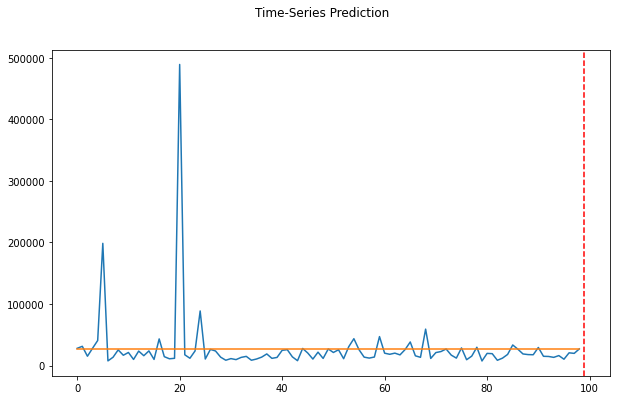

In [340]:
lstm1.eval()
train_predict = lstm1(x_train_tensors_final)

data_predict = train_predict.data.numpy()
dataY_plot = y_train_tensors.data.numpy()

# data_predict = sc.inverse_transform(data_predict)
# dataY_plot = sc.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=99, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

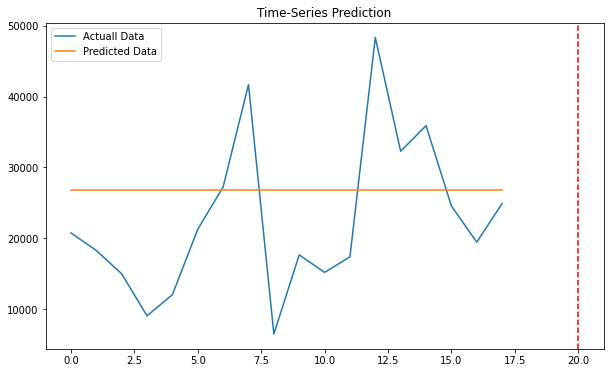

In [262]:
#df_X_sc = sc.transform(x)
# df_y_sc = sc.transform(y)

# df_X_sc = Variable(torch.Tensor(df_X_sc)) #converting to Tensors
#reshaping the dataset
# df_X_sc = torch.reshape(df_X_sc, (df_X_sc.shape[0], 1, df_X_sc.shape[1]))
train_predict = lstm1(x_test_tensors_final.to(device))#forward pass
data_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
dataY_plot = y_test_tensors.data.numpy()

# data_predict = sc.inverse_transform(data_predict) #reverse transformation
# dataY_plot = sc.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=20, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show()